In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from ipynb.fs.full.data_wrangling import * #Data preprocessing notebook
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

SCORINGS = [
    'accuracy'
#     'f1',
#     'precision',
#     'recall',
#     'roc_auc'
]

cv_splits = 5
repetitions = 3
RANDOM_STATE = 42
cross_validation_setting = RepeatedStratifiedKFold(n_splits=cv_splits,
                                                   n_repeats=repetitions,
                                                   random_state= RANDOM_STATE)

def model_evaluation(model, features, target, 
                     cv = cross_validation_setting):
    scores = dict()
    formatted_scores = dict()
    formatted_scores['model'] = model
    for score_metric in SCORINGS:
        scores[score_metric] = cross_val_score(model,
                                               features,
                                               target,
                                               scoring = score_metric)
        formatted_scores[score_metric + " score"] = scores[score_metric].mean()
        formatted_scores[score_metric + " std"] = scores[score_metric].std()
        fig = plt.figure()
        fig.suptitle('Algorithm Comparison')
        ax = fig.add_subplot(111)
        plt.boxplot(scores[score_metric])
        plt.show()
    
    return formatted_scores


    
    
    

In [23]:
"""
Config for every experiment
"""
RANDOM_STATE = 0
VOTING_METHOD = 'soft'
results = pd.DataFrame(columns = ['model', "accuracy score", "accuracy std"])


In [24]:
"""
Getting the best weak learners (GridSearchCV section)
"""
from sklearn.model_selection import GridSearchCV
# --------------------------------------------

C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNOR

C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Nathan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

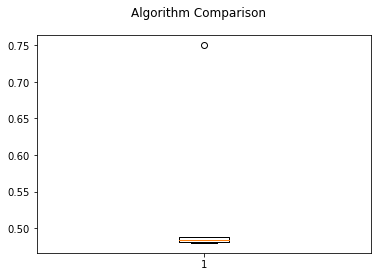

In [25]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg_grid={'C':[0.001,0.01,.09,1,5,10],
              "penalty":["l1","l2"]} #l1 lasso l2 ridge
lr = LogisticRegression(random_state=RANDOM_STATE)
log_reg_gridsearch = GridSearchCV(lr, param_grid = log_reg_grid,
                             refit = True)
selected_log_reg = log_reg_gridsearch.fit(X,Y).best_estimator_
results = results.append(model_evaluation(selected_log_reg, X, Y), ignore_index = True)

In [26]:
results

,model,accuracy score,accuracy std
0,"LogisticRegression(C=10, random_state=0)",0.536891,0.106587


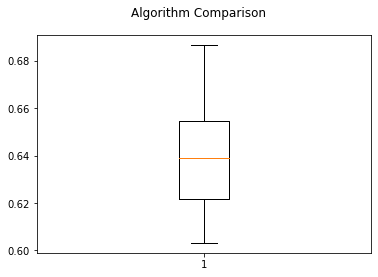

In [27]:
"""
K Neighbors
"""
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

knn_grid = dict(n_neighbors = k_range, 
                weights = weight_options)
knn = KNeighborsClassifier()
knn_gridsearch =GridSearchCV(knn, param_grid = knn_grid,
                             refit = True)
selected_knn = knn_gridsearch.fit(X, Y).best_estimator_
results = results.append(model_evaluation(selected_knn, X , Y), ignore_index = True)

In [28]:
results

,model,accuracy score,accuracy std
0,"LogisticRegression(C=10, random_state=0)",0.536891,0.106587
1,"KNeighborsClassifier(n_neighbors=6, weights='d...",0.640969,0.028549


In [ ]:
"""
Support Vector Machines
"""
from sklearn.svm import SVC

svm_grid = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']} 
  
svm_gridsearch = GridSearchCV(SVC(),
                              param_grid = svm_grid,
                              refit = True)

selected_svm = svm_gridsearch.fit(X,Y).best_estimator_
model_evaluation(selected_svm, X , Y)

In [ ]:
results

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_gridsearch = GridSearchCV(estimator=nb, 
                     param_grid = nb_params,
                     refit = True)
selected_nb = nb_gridsearch.fit(X,Y).best_estimator_
model_evaluation(selected_nb, X, Y)


In [ ]:
"""Boosting Algorithms"""
from sklearn.ensemble import AdaBoostClassifier
boosting_models = dict()

In [ ]:
#AdaBoost
ab_param_grid = {
    'n_estimators' : [100, 300, 500],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}
ab_model = AdaBoostClassifier(random_state = RANDOM_STATE)
xgb_gridsearch = GridSearchCV(ab_model,
                              param_grid = ab_param_grid,
                              refit = True)

selected_xgb = xgb_gridsearch.fit(X, Y).best_estimator_
model_evaluation(selected_xgb, X, Y)

In [ ]:
#XGBoost
import xgboost as xgb

parameters = {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [200, 400],
            'gamma': [0.01, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'max_delta_step': [0],
            'subsample': [0.7, 1],
            'colsample_bytree': [0.6, 1],
            'reg_alpha': [0, 1e-2, 1],
            'reg_lambda': [0, 1e-2, 1],
            }

xgb_model = xgb.XGBClassifier(silent = True,
                              random_state = RANDOM_STATE)

xgb_gridsearch = GridSearchCV(xgb_model,
                              parameters,
                              refit = True)

selected_xgb = xgb_gridsearch.fit(X, Y).best_estimator_
model_evaluation(selected_xgb, X, Y)

In [ ]:
"""Bagging Algorithms"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_models = dict()
bagging_models['rf'] = RandomForestClassifier(random_state = RANDOM_STATE)
bagging_models['et'] = ExtraTreesClassifier(random_state = RANDOM_STATE)
bagging_models['bdt'] = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state = RANDOM_STATE)


In [ ]:
#RandomForest
rf_grid = {
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 400]
}

rf = RandomForestClassifier(random_state = RANDOM_STATE)
rf_gridsearch = GridSearchCV(rf, param_grid = rf_grid,
                             refit = True)
selected_rf = rf_gridsearch.fit(X, Y).best_estimator_
model_evaluation(selected_rf, X, Y)

In [ ]:
#Extra Trees

et_grid = {
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 400],
    'oob_score': [True, False]
}

In [ ]:
"""Stacking Ensemble"""
from sklearn.ensemble import StackingClassifier

stacking_estimators = [
    ('lr', selected_lr),
    ('knn', selected_knn),
    ('svm', selected_svm),
    ('gnb', selected_nb),
    ('dt', selected_dt)
]

final_estimator = selected_lr

stacking_model = StackingClassifier(estimators = stacking_estimators,
                                    final_estimator = final_estimator)



In [ ]:
"""Voting Ensemble"""
from sklearn.ensemble import VotingClassifier

voting_estimators = [
    ('lr', LogisticRegression(random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(random_state=RANDOM_STATE)),
    ('gnb', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE))
]

voting_classifier = VotingClassifier(voting_estimators,
                                     voting=VOTING_METHOD)